In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Apr  1 20:55:40 2019

@author: mu
"""




import numpy as np

import pandas as pd

from pandas import Series, DataFrame

import matplotlib.pyplot as plt

from data_clean import Stock

def loss(real_v,model_v):
        # Root Mean Square Error
        RMSE=np.sqrt(np.nanmean(np.square(real_v-model_v)))
        #Mean Absolute Percent Error
        MAPE=np.nanmean(np.abs(real_v-model_v)/real_v)
        #Mean absolute Error
        MAE=np.nanmean(np.abs(real_v-model_v))
        return DataFrame([RMSE,MAPE,MAE],index=["RMSE","MAPE","MAE"],columns=['loss'])
def a(n,x,derivative=False):
    a=np.matrix(np.array([x**i for i in reversed(range(n))]))
    b=np.matrix(np.array([i*x**(i-1) for i in reversed(range(n))]))
    if derivative:
        return a*(n*x**(n-1)+(1-n)*x**n-1)/(1-x**n)**2+b*(1-x)/(1-x**n)
    else:
        return a*(1-x)/(1-x**n)
    
def fit(X,target,hold_out,rate=0.001,beta=0.9,error=10**-16,iteration=10**4,observe=False):
    """x is the trainning set, Y is monthly volatility,d is the day lag used
    use gradient descent to minimize mean square loss
    both X,Y are numpy.ndarray
    """
    minloss=10**8
    best_mu=0
    day=0
    
    for d in range(5,63):
        Y=np.array(target[d+21:])
        np.random.seed()
        mu=np.random.uniform(0.1,1)
        A=np.matrix(np.zeros((d,d)))
        v2=np.matrix(np.zeros(d))
    
        N=hold_out
        for i in range(N):
            v2+=Y[i]*X[i:i+d]
            A+=np.matrix(X[i:i+d]).T*np.matrix(X[i:i+d])
        step=0
        g_mu=0.1
    
        update_mu=0.1
        while step<iteration and g_mu>error:
            g_mu=np.asscalar((-v2+a(d,mu)*A)*a(d,mu,True).T)
            update_mu=update_mu*beta+g_mu*(1-beta)
            mu-=rate*update_mu
            step+=1
            if step%100==0 and observe:
                L=0
                for i in range(N):
                    L+=(Y[i]-np.asscalar(a(d,mu)*np.matrix(X[i:i+d]).T))**2
                print("mu,gradient,loss",mu,g_mu,np.sqrt(L/N))
        Loss_total=0
        for i in range(len(Y)):
            if i<N:
                Loss_total+=np.abs((1-np.asscalar(a(d,mu)*np.matrix(X[i:i+d]).T)/Y[i]))
            # here we put more weight on out_of_sample_loss
            else:
                Loss_total+=np.abs((Y[i]-np.asscalar(a(d,mu)*np.matrix(X[i:i+d]).T))/Y[i])*2
            
        if Loss_total<minloss:
            best_mu,day,minloss=mu,d,Loss_total
    Y=np.array(target[day+21:])
    Loss_in_sample,Loss_out_of_sample=0,0
    In_sample_fit=np.zeros(N)
    for i in range(N):
        In_sample_fit[i]=np.asscalar((a(day,best_mu)*np.matrix(X[i:i+day]).T))
    Loss_in_sample=np.sum(np.square(Y[:N]-In_sample_fit))
    RMSE_in_sample=np.sqrt(Loss_in_sample/N)
    
    
    num_hold_out=len(Y)-N
    out_of_sample_fit=np.zeros(len(target))
    for i in range(N,N+num_hold_out):
        out_of_sample_fit[i]=np.asscalar((a(day,best_mu)*np.matrix(X[i:i+day]).T))
        Loss_out_of_sample +=(Y[i]-out_of_sample_fit[i])**2
    RMSE_out_of_sample=np.sqrt(Loss_out_of_sample/num_hold_out)
    # predict monthly volatility
    predict=np.asscalar((a(day,best_mu)*np.matrix(X[-1-day:-1]).T))
    plt.plot(In_sample_fit)
    plt.plot(out_of_sample_fit)
    plt.plot(Y)
    print("in smaple RMSE",RMSE_in_sample)
    print("out of smaple RMSE", RMSE_out_of_sample)
    print('predict monthly volatility',predict)
    print('day,mu',day,best_mu)
        



# the unit here is annualized volatility

/home/mu/Downloads/monthly_vol_code/stockdata/data_clean.py:17: RuntimeWarning: divide by zero encountered in log
  self.logprice.loc[:,'a':]=np.log(self.price.loc[:,'a':])


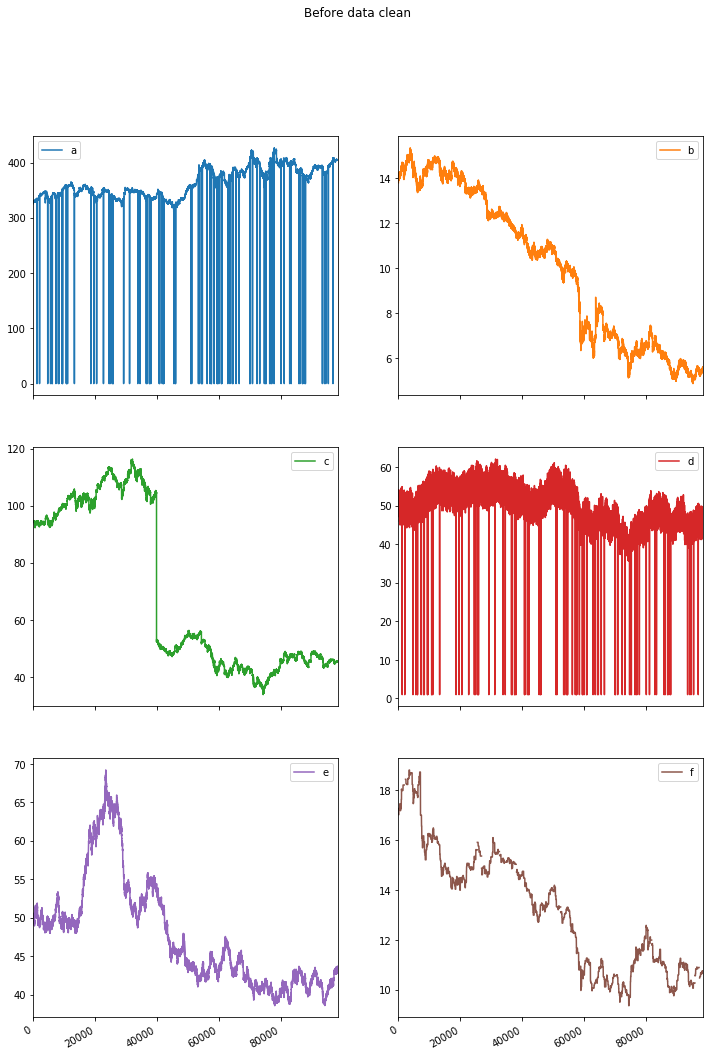

In [2]:

stockprice=pd.read_csv('stockdata2.csv')
stockprice.loc[:,'a':].plot(title='Before data clean',subplots=True,layout=(3,2),figsize=(12,18))
stk=Stock(stockprice)

# First we clean errors that are 0,1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2299d26f98>,
      dtype=object)

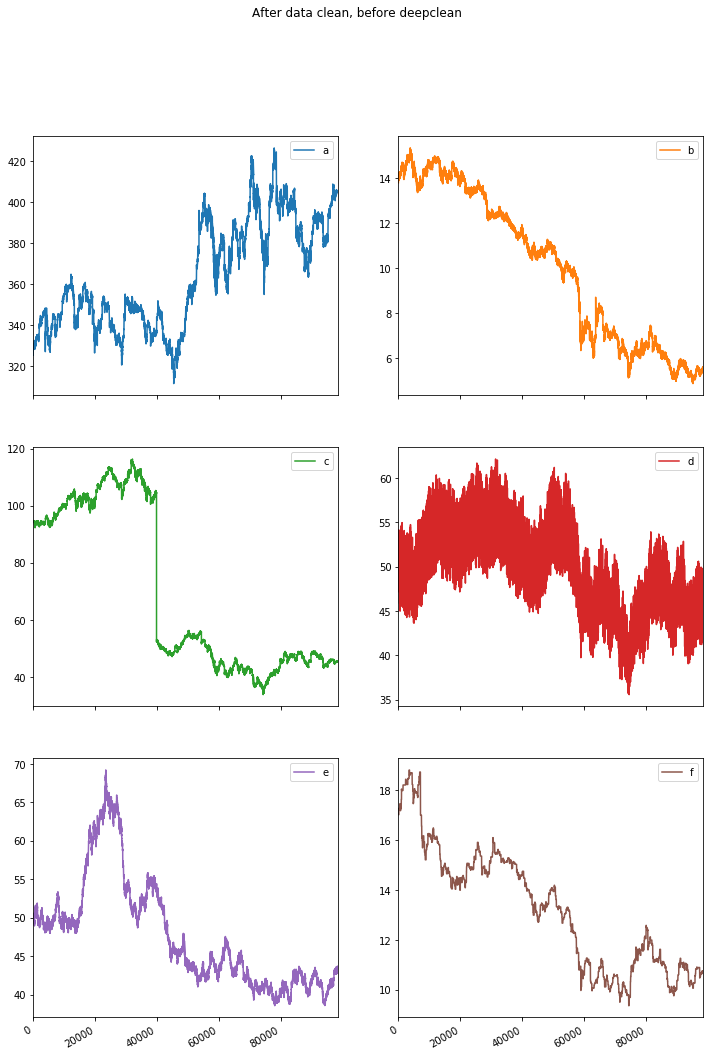

In [3]:

stk.clean()
stk.price.loc[:,'a':].plot(title='After data clean, before deepclean',subplots=True,layout=(3,2),figsize=(12,18))

# Now we are going to deepclean the data, notably for d, this method is data-driven. It differentiate graph c and d

/home/mu/Documents/Jupyter workspace/stockdata/data_clean.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.price.loc[:,stk][(np.abs(self.logprice.loc[:,stk]-leftmean.shift(1))>leftstd.shift(1))&( np.abs(self.logprice.loc[:,stk]-leftmean.shift(-timewindow))>leftstd.shift(-timewindow))]=np.nan


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2299b90eb8>,
      dtype=object)

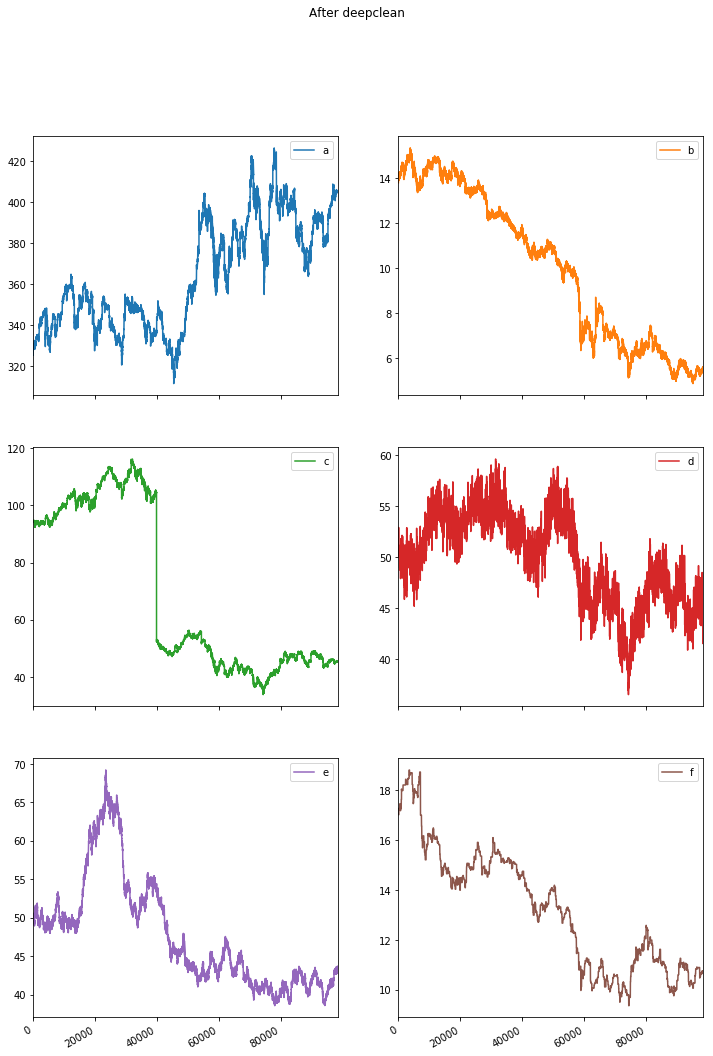

In [4]:
stk.deepclean(['a','b','c','d','e','f'])

stk.price.loc[:,'a':].plot(title='After deepclean',subplots=True,layout=(3,2),figsize=(12,18))

# The price for stock c plummeted to half of its trading price, due to a possible stock split

/home/mu/Documents/Jupyter workspace/stockdata/data_clean.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.price[stk][:split_time+1]/=2


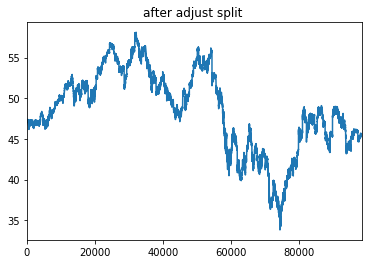

In [5]:
stk.split_adjust('c')
stk.price.c.plot(title="after adjust split ")

In [34]:
end=98351

5 min           loss
RMSE  0.000052
MAPE  0.000443
MAE   0.000039
30 min           loss
RMSE  0.000425
MAPE  0.003964
MAE   0.000359
390 min           loss
RMSE  0.003743
MAPE  0.034493
MAE   0.003059


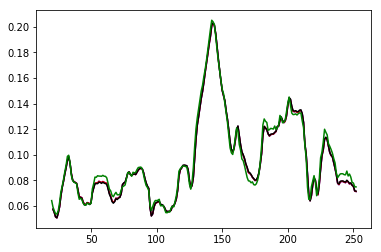

In [35]:
#monthly volatility of a: sample frequency: 1 min
mvol_a1=stk.monthly_vol('a',0,end)
#monthly volatility of a: sample frequency: 5 min
mvol_a5=stk.monthly_vol('a',0,end,samplegap=5)
#monthly volatility of a: sample frequency: 30 min
mvol_a30=stk.monthly_vol('a',0,end,samplegap=30)
#monthly volatility of a: sample frequency: daily
mvol_a390=stk.monthly_vol('a',0,end,samplegap=390)
plt.plot(mvol_a1,color="blue")
plt.plot(mvol_a5,color="red")
plt.plot(mvol_a30,color="black")
plt.plot(mvol_a390,color="green")
# loss function for different sampling frequency
print("5 min",loss(mvol_a1,mvol_a5))
print("30 min",loss(mvol_a1,mvol_a30))
print("390 min",loss(mvol_a1,mvol_a390))

# The monthly volatility is insensitive to intraday sampling frequency

5 min           loss
RMSE  0.001218
MAPE  0.013267
MAE   0.000902
30 min           loss
RMSE  0.007592
MAPE  0.081195
MAE   0.005671
65 min           loss
RMSE  0.015598
MAPE  0.153927
MAE   0.011444


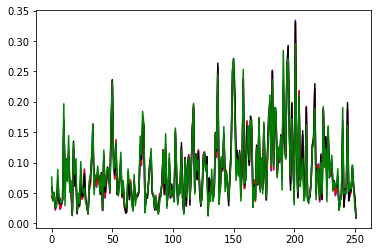

In [36]:
#daily volatility of a: sample frequency: 1 min
dvol_a1=stk.vol('a',0,end)
#daily volatility of a: sample frequency: 5 min
dvol_a5=stk.vol('a',0,end,samplegap=5)
#daily volatility of a: sample frequency: 30 min
dvol_a30=stk.vol('a',0,end,samplegap=30)
#dailyvolatility of a: sample frequency: daily
dvol_a65=stk.vol('a',0,end,samplegap=65)
plt.plot(dvol_a1,color="blue")
plt.plot(dvol_a5,color="red")
plt.plot(dvol_a30,color="black")
plt.plot(dvol_a65,color="green")
# loss function for different sampling frequency
print("5 min",loss(dvol_a1,dvol_a5))
print("30 min",loss(dvol_a1,dvol_a30))
print("65 min",loss(dvol_a1,dvol_a65))

# For daily volatility, 5min and 30 min sampling gap are almost as good as 1min sampling gap, so we will be using 30 min sampling gap


,loss
RMSE,0.180483
MAPE,2.322245
MAE,0.151777


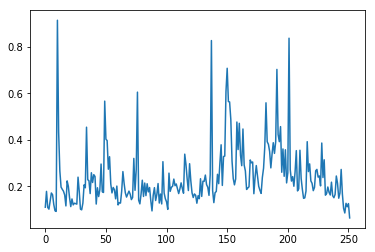

In [37]:
# other measures of volatility:
#daily realized volatility
drealized_vol_a=stk.rlz_vol("a",0,end)
plt.plot(drealized_vol_a)
loss(dvol_a1,drealized_vol_a)

,loss
RMSE,0.081232
MAPE,1.167330
MAE,0.066652


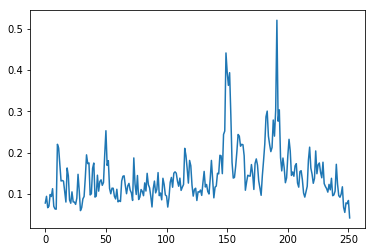

In [38]:
#daily absolute log return
dabs_logrtn_a=stk.abs_logrtn('a',0,end)
plt.plot(dabs_logrtn_a)
loss(dvol_a1,dabs_logrtn_a)

# daily absolute return seems better than daily realized volatility

# we will use EWMA method as our model. The function fit() will perform gradient descent with momentum method to minimize RMSE. (Here we use mean squared loss)

# 1) use realized_volatility to predict monthly volatility

in smaple RMSE 0.16940031292397337
out of smaple RMSE 0.19405576315197282
predict monthly volatility 0.14904367231808083
day,mu 62 0.8446665615915178


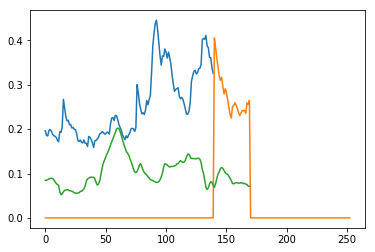

In [70]:
# we use 150 days as sample, and hold out the rest to test the performance of the model
fit(drealized_vol_a,mvol_a1,hold_out=140)

# 2) use absolute_logreturn to predict monthly volatility

in smaple RMSE 0.07558017692750092
out of smaple RMSE 0.07356322680524717
predict monthly volatility 0.0985551521074357
day,mu 61 0.8850206495485602


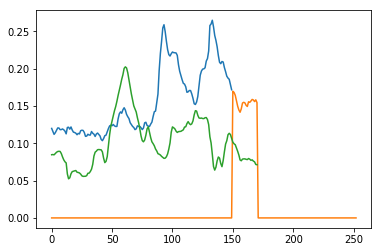

In [71]:
# we use 150 days as sample, and hold out the rest to test the performance of the model
fit(dabs_logrtn_a,mvol_a1,hold_out=150)

# 3) use daily volatility to predict monthly volatility 

in smaple RMSE 0.04364677931390372
out of smaple RMSE 0.033670706261525754
predict monthly volatility 0.08187512745120118
day,mu 60 0.9468506253826746


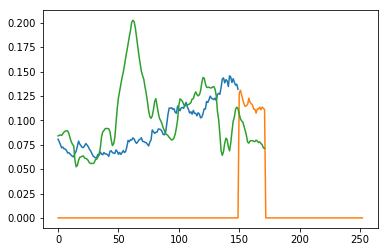

In [72]:
# we use 150 days as sample, and hold out the rest to test the performance of the model
fit(dvol_a30,mvol_a1,hold_out=150)

# a) we predict monthly volatility 0.082, with RMSE 0.034

# It seems that daily volatility is a better predictor than the other two under the current model. Here we used 30 min sampling gap for daily volatility

In [79]:
# we calculate the monthly volatility and daily volatility
mvol_b=stk.monthly_vol('b',0,end)
mvol_c=stk.monthly_vol('c',0,end)
mvol_d=stk.monthly_vol('d',0,end)
mvol_e=stk.monthly_vol('e',0,end)
mvol_f=stk.monthly_vol('f',0,end)
dvol_b30=stk.vol('b',0,end,samplegap=30)
dvol_c30=stk.vol('c',0,end,samplegap=30)
dvol_d30=stk.vol('d',0,end,samplegap=30)
dvol_e30=stk.vol('e',0,end,samplegap=30)
dvol_f30=stk.vol('f',0,end,samplegap=30)

in smaple RMSE 0.12893868993164082
out of smaple RMSE 0.08125746087180549
predict monthly volatility 0.23119116023069308
day,mu 53 0.9334693024601418


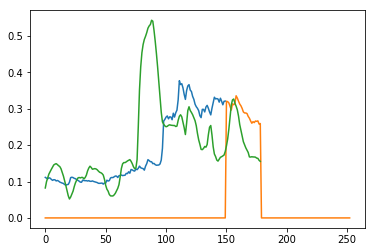

In [77]:
# we use 150 days as sample, and hold out the rest to test the performance of the model
fit(dvol_b30,mvol_b,hold_out=150)

# b) we predict monthly volatility 0.231, with RMSE 0.081

in smaple RMSE 0.3595219988835522
out of smaple RMSE 0.07333612592201029
predict monthly volatility 0.12631894013627545
day,mu 49 0.9528396764529566


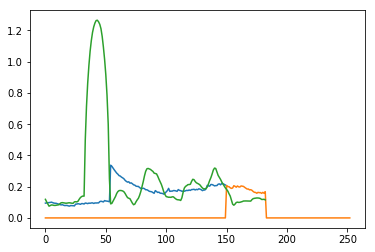

In [80]:
# we use 150 days as sample, and hold out the rest to test the performance of the model
fit(dvol_c30,mvol_c,hold_out=150)

# c) we predict monthly volatility 0.126, with RMSE 0.073

in smaple RMSE 0.04868761499491874
out of smaple RMSE 0.050091349136421645
predict monthly volatility 0.1278899674265727
day,mu 59 0.9668806923461123


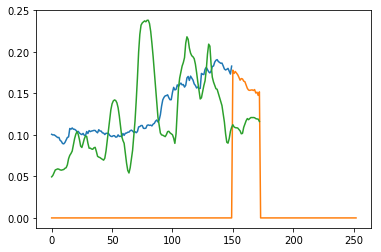

In [81]:
# we use 150 days as sample, and hold out the rest to test the performance of the model
fit(dvol_d30,mvol_d,hold_out=150)

# d) we predict monthly volatility 0.128, withRMSE 0.050

in smaple RMSE 0.06490326200360037
out of smaple RMSE 0.04091032439886848
predict monthly volatility 0.10423141829381452
day,mu 53 0.8639359381562307


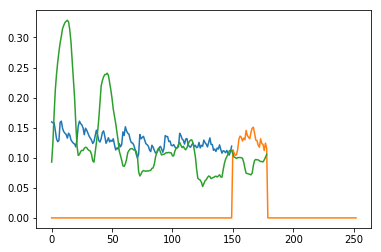

In [85]:
# we use 150 days as sample, and hold out the rest to test the performance of the model
fit(dvol_e30,mvol_e,hold_out=150)

# e) we predict monthly volatility 0.104, with RMSE 0.041

in smaple RMSE 0.07407373847315009
out of smaple RMSE 0.01496765916713957
predict monthly volatility 0.1331179979217845
day,mu 58 0.9383442984158299


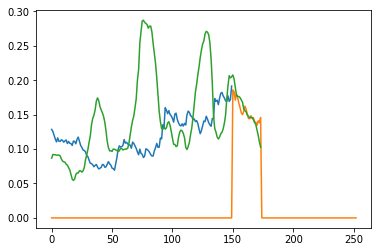

In [84]:
# we use 150 days as sample, and hold out the rest to test the performance of the model
fit(dvol_f30,mvol_f,hold_out=150)

# f) we predict monthly volatility 0.133, with RMSE 0.015